In [1]:
import os
import csv
import argparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.utils as utils
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.models import vgg16_bn
from sklearn.metrics import confusion_matrix

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_ids = [0]

root_dir = "/home/rishab/alexnet_attention/test"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
testset = datasets.ImageFolder(root=root_dir,transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 0 -> Advertisement


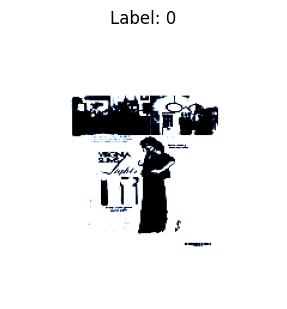

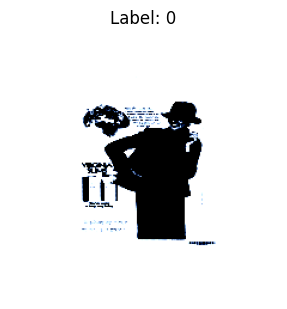

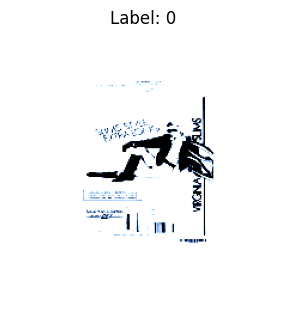

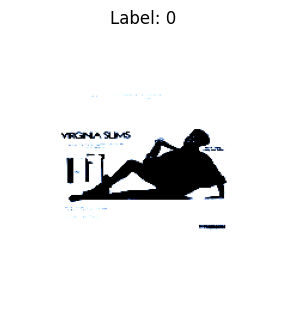

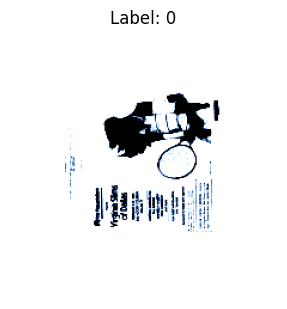

In [3]:
num_samples_to_display = 5
sample_indices = range(num_samples_to_display)
samples = [testset[i] for i in sample_indices]

# Display the sample images and labels
for i, (sample_image, sample_label) in enumerate(samples):
    # Convert sample image tensor to NumPy array
    sample_image_np = np.transpose(sample_image.numpy(), (1, 2, 0))
    plt.figure(figsize=(20,10))
    plt.subplot(1, num_samples_to_display, i+1)
    plt.imshow(sample_image_np)
    plt.title(f"Label: {sample_label}")
    plt.axis("off")
print("Label: 0 -> Advertisement")
plt.show()

In [10]:
net = models.vgg16_bn(weights=torchvision.models.VGG16_BN_Weights.IMAGENET1K_V1)
num_classes = 16
net.classifier[6] = torch.nn.Linear(4096, num_classes)

In [14]:
checkpoint = torch.load("last_model_vgg_16.pth")
net.load_state_dict(checkpoint)
model = nn.DataParallel(net, device_ids=device_ids).to(device)
model.eval()

#Testing
writer = SummaryWriter("logs_vgg_16_test_last_model")
all_preds = []
all_labels = []
with torch.no_grad():
    total = 0
    correct = 0
    for images,labels in testloader:
        inputs = images.to(device)
        labels = labels.to(device)
        pred_test = model(inputs)
        _,predict = torch.max(pred_test, 1)
        total += labels.size(0)
        correct += (predict == labels).sum().item()
        all_preds.extend(predict.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
# Calculate and print accuracy
print("Correct_Predictions",correct)
print("Total",total)
accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")

# Confusuion Matrix
CM = confusion_matrix(all_labels, all_preds, labels=list(range(16)))


acc = np.sum(np.diag(CM)) / np.sum(CM)

print('\nTestset Accuracy(mean): %f %%' % (100 * acc))
print()
print('Confusion Matirx : ')
print(CM)

class_sensitivity = []
class_precision = []
class_metrics = []

csv_filename = "test_results_vgg16_bn_last_model.csv"
with open(csv_filename, mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)

    writer.writerow(["Class","Sensitivity","Precision"])
    for class_idx in range(num_classes):
        tp = CM[class_idx, class_idx]
        fn = np.sum(CM[class_idx, :]) - tp
        fp = np.sum(CM[:, class_idx]) - tp
        tn = np.sum(CM) - tp - fn - fp
        
        sensitivity = tp / (tp + fn)
        precision = tp / (tp + fp)
        class_sensitivity.append(sensitivity)
        class_precision.append(precision)

        writer.writerow([f"Class {class_idx}"])
        writer.writerow(["Sensitivity",sensitivity])
        writer.writerow(["Precision", precision])
        class_metrics.append([sensitivity, precision])
        
        # Write mean metrics
        mean_sensitivity = np.mean(class_sensitivity)
        mean_precision = np.mean(class_precision)
        writer.writerow(["Mean Sensitivity", mean_sensitivity])
        writer.writerow(["Mean Precision", mean_precision])

        print(f'Class {class_idx}:')
        print('- Sensitivity:', sensitivity)
        print('- Precision:', precision)
        print()
    
    # Write confusion matrix
    writer.writerow([])
    writer.writerow(["Confusion Matrix"])
    writer.writerows(CM)
  
print('Mean Sensitivity:', mean_sensitivity)
print('Mean Precision:', mean_precision)

Correct_Predictions 1906
Total 3200
Accuracy: 59.56%

Testset Accuracy(mean): 59.562500 %

Confusion Matirx : 
[[173   0   0   0   2   8   2   1   2   7   0   3   0   0   0   2]
 [  2 105   1   5  10   1  15   0   1   0  12   8   0   1  22  17]
 [  1   1 173   2   0   0   0   1   5   1   2   2   2   7   3   0]
 [ 12  22   1 134   1   2   2   1   1   2   7   0   0   1  14   0]
 [  3   7   1   4  79   0  27   4  32   4  10   2   0   1  25   1]
 [  6   0   0   1   7 176   2   2   0   2   0   1   0   0   0   3]
 [  1  28   2   4  39   1  90   4   6   2   2   3   0   1  12   5]
 [  4   5   0   2  19   2   4 108  14   5   9  11   0   2  12   3]
 [  7   2   2   2   2   0   3  21 115   1  11   8   2   3  21   0]
 [  9   1   7   0   2   0   1   1   0 149  12   3   2   6   7   0]
 [  6   3   4   5   3   3   0   7   7   3 125  12   0   4  18   0]
 [  2  17   9   1  20   0   1   5   4   9   4 102   1   1  20   4]
 [  0   0   0   0   0   0   0   0   0   0   0   1 193   0   6   0]
 [  8   3   1  16 